# All the Required Libraries 


In [812]:
import getpass
import os

import functools

import operator

import ast
import base64
import io
import json

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.tools.yahoo_finance_news import YahooFinanceNewsTool
from langchain_community.tools.google_finance import GoogleFinanceQueryRun
from langchain_community.utilities.google_finance import GoogleFinanceAPIWrapper
from langchain_community.utilities import SQLDatabase

from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

from langchain_groq import ChatGroq

from typing import Annotated, List, Dict, Optional, TypedDict

import sqlite3
import pymysql
import pandas as pd

from pathlib import Path
from tempfile import TemporaryDirectory

from langchain.agents import AgentExecutor,create_tool_calling_agent,create_sql_agent

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder,SystemMessagePromptTemplate, HumanMessagePromptTemplate
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage, ToolMessage

from langchain.agents import Tool


from langgraph.graph import END, StateGraph, START

import regex as re

from langchain_core.pydantic_v1 import BaseModel, Field

from langchain.tools import DuckDuckGoSearchRun
from langchain.utilities import WikipediaAPIWrapper

from matplotlib.pyplot import imshow
from PIL import Image


# DATABASE SETUP

In [813]:
from urllib.parse import quote
db_config = {
    'host': 'localhost', 
    'port': 3306, 
    'user': 'Pratheek', 
    'password': 'Newuser@123',
    'database': 'LLM_Testing'
}


encoded_password = quote(db_config['password'])

connection = pymysql.connect(
    host=db_config['host'],
    port=db_config['port'],
    user=db_config['user'],
    password=db_config['password'],
    database=db_config['database']
)

SQL_DB_CONNECTION_STRING = f"mysql+pymysql://{db_config['user']}:{encoded_password}@{db_config['host']}:{db_config['port']}/{db_config['database']}"
db = SQLDatabase.from_uri(SQL_DB_CONNECTION_STRING)


In [814]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Multi-agentBAFramework"

# Setting up Environment Variables

In [815]:
def set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


In [816]:
set_if_undefined("LANGCHAIN_API_KEY")

In [817]:
set_if_undefined("GROQ_API_KEY")

In [818]:
set_if_undefined("TAVILY_API_KEY")

In [819]:
set_if_undefined("SERPAPI_API_KEY")

In [820]:

# _TEMP_DIRECTORY = TemporaryDirectory()
# WORKING_DIRECTORY = Path(_TEMP_DIRECTORY.name)

PROJECT_PATH = Path.cwd() / "/Users/pratheekkb/PycharmProjects/MultiAgent_Llama3_DataScientist/Datasets"
PROJECT_PATH.mkdir(parents=True, exist_ok=True)
WORKING_DIRECTORY = PROJECT_PATH

# Function calling Tools

In [821]:
#Tavily for general Search
tavily_tool = TavilySearchResults(max_results=1)

#Finance News
google_finance_tool = GoogleFinanceQueryRun(api_wrapper=GoogleFinanceAPIWrapper())

search = DuckDuckGoSearchRun()
wikipedia = WikipediaAPIWrapper()

# Repl for Dynamic code execution
repl = PythonREPL()

duckduckgo_tool = Tool(
    name='DuckDuckGo Search',
    func= search.run,
    description="Useful for when you need to do a search on the internet to find information that another tool can't find. be specific with your input."
)
wikipedia_tool = Tool(
    name='wikipedia',
    func= wikipedia.run,
    description="Useful for when you need to look up a topic, country or person on wikipedia"
)




# Creating Nodes


#### Defining graph state and schemas

In [822]:
class GraphState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    task: Annotated[str,"Task to be completed"]
    code_gen: Annotated[str,"Generated python code"]
    raw_tool_messages: Annotated[List[BaseMessage], operator.add]

In [823]:
class RawToolMessage(ToolMessage):
    """
    Customized Tool message that lets us pass around the raw tool outputs (along with string contents for passing back to the model).
    """
    raw: dict
    """Arbitrary (non-string) tool outputs. Won't be sent to model."""
    tool_name: str
    """Name of tool that generated output."""

In [824]:

class create_df_from_sql(BaseModel):
    """Execute a MySQL SELECT statement and use the results to create a DataFrame with the given column names."""

    select_query: str = Field(..., description="A MySql SELECT statement.")

    df_columns: List[str] = Field(
        ..., description="Ordered names to give the DataFrame columns."
    )
    df_name: str = Field(
        ..., description="The name to give the DataFrame variable in downstream code."
    )



In [825]:

class python_shell(BaseModel):
    """Execute Python code that analyzes the DataFrames that have been generated. Make sure to print any important results."""

    code: str = Field(
        ...,
        description="The code to execute. Make sure to print any important results.",
    )
    explanation: str = Field(
        ...,
        description="Describing the performed task",
    )
    


#### Defining Nodes

In [826]:
sql_llm = ChatGroq(model="llama3-70b-8192")

def SQL_Writer(state: GraphState) -> dict:
    """Call model for structured Output."""
    
    SQL_Writer_prompt = (
    f"""
    You are an expert at MySQL. 
    You have access to a MySQL database with the following tables: 
    \n\n
    
    {db.table_info}
    
    \n\n
    Your task is to  get the relevant data from the table as a DataFrame using the create_df_from_sql tool.

    """
)
    

    
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", SQL_Writer_prompt),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )

    agent = prompt | sql_llm.with_structured_output(create_df_from_sql)

    response = agent.invoke(state)

    return {"raw_tool_messages": [response]}



In [827]:
(SQL_Writer({"messages":[],"task":"Fetch table","code_gen":"","raw_tool_messages":[]}))

{'raw_tool_messages': [create_df_from_sql(select_query='SELECT * FROM RetailShop', df_columns=['ProductID', 'ProductName', 'Category', 'Price', 'Quantity', 'SupplierName', 'SupplierContact', 'Sales'], df_name='retail_shop_df')]}

In [828]:

python_llm = ChatGroq(model="llama3-70b-8192")

def Python_Programmer(state: GraphState) -> dict:
    """Call model for structured Output."""
    
    Python_Programmer_prompt = (
    """Never forget you are a Python_Programmer and I am a Data_Scientist. 
    Never flip roles!
    We share a common interest in collaborating to successfully complete a task.
    You must help me to complete the task.
    Here is the task: {task}. Never forget our task!
    I will instruct you based on your expertise and my needs to complete the task.
    I must give you one question at a time.
    
    You must write python code that appropriately completes the requested question using python_shell tool.
    
    Do not add anything else other than your answer to my instruction.
    
    """
    )

    # Create the prompt template
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", Python_Programmer_prompt),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )

    agent = prompt | python_llm.with_structured_output(python_shell)

    res = agent.invoke(state)
    

    
    response = "My Response:\n" + res.explanation + "\n\n" + "````python \n\n" + res.code + "\n\n" + "```` \n" + "Next Question."
    
    return {
        "messages": [HumanMessage(content=response, name="Python_Programmer")],
        "code_gen": (
                        #state["code_gen"] + '\n\n' + 
                        res.code
        )
    }



In [829]:
# t=(Python_Programmer({"messages":[],"task":"Write a Python code to fetch all distinct categories from the RetailShop dataframe.","code_gen":""}))

In [830]:
# print(t['messages'][0].content)

In [831]:
ai_user_llm = ChatGroq(model="llama3-70b-8192")

def UserAgent(state: GraphState) -> dict:
    user_inception_prompt = (
    """Never forget you are a Data_Scientist and we are an assistant team whose names are SQL_Writer , Python_Programmer, Internet_finder. 
    Never flip roles! You will always ask us.
    Never flip roles among assistant_members too, each one has their own speciality!
    We share a common interest in collaborating to successfully complete a task.
    We must help you to answer the questions.
    
    Here is the database schema of the company you should never forget : {schem}
    
    Here is the task: {task}. Never forget our task!
    You must instruct me based on our expertise and your needs to complete the task ONLY in the following two ways:
    
    1. Instruct with a necessary input:
    Assistant_Name: <ASSISTANT_NAME>
    Instruction: <YOUR_INSTRUCTION>
    Input: <YOUR_INPUT>
    
    2. Instruct without any input:
    Assistant_Name: <ASSISTANT_NAME>
    Instruction: <YOUR_INSTRUCTION>
    Input: None
    
    The "Assistant_Name" is the name of the assistant you want to perform working based on their speciality.The "Instruction" describes a task or question. The paired "Input" provides further context or information for the requested "Instruction".
    
    Never forget the tasks we can do :
    SQL_Writer: I can help you to fetch table from database and convert it into pandas dataframe.
    Python_Programmer:I can help you to write python code.
    Internet_finder: I can browse over the internet for finding information.
    
    You must give us one instruction at a time.
    One of us whom you called  must write a response that appropriately completes the requested instruction.
    One of us whom you called must decline your instruction honestly if one of us you called cannot perform the instruction due to physical, moral, legal reasons or my capability and explain the reasons.
    You should instruct us not to ask you questions.
    Now you must start to instruct one of us whom you called using the two ways described above.
    Do not add anything else other than Assistant name,your instruction and the optional corresponding input!
    Keep giving  instructions and necessary inputs until you think the task is completed.
    
    Always remember to output in the format mentioned before :- Assistant_Name:..., Instruction:... and Input:... !
    
    Once the task is completed, analyze the results and provide report.
    When the task is completed, you must only reply with a single word <TASK_DONE>.
    Never say <TASK_DONE> unless our responses has solved your task.
    
    """
    )
    
    user_inception_prompt=user_inception_prompt.format(schem=db.table_info,task="{task}")
   
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                user_inception_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    agent= prompt | ai_user_llm
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result.content, name="Data_Scientist")]}


In [832]:
def execute_sql_query(state: GraphState) -> dict:
    """Execute the latest SQL queries."""
   
    
    sql_code = state["raw_tool_messages"][-1].select_query
    res = db.run(sql_code, fetch="cursor").fetchall()


    df_columns = state["raw_tool_messages"][-1].df_columns
    
    df = pd.DataFrame(res, columns=df_columns)
    
    df_name = state["raw_tool_messages"][-1].df_name
    
    file_path = os.path.join(WORKING_DIRECTORY, df_name + ".csv")
    
    df.to_csv(file_path, index=False)

    return {"messages": [HumanMessage(content=f"Generated dataframe {df_name} with columns {df_columns} and saved it to {file_path}", name="SQL_Writer")]}

In [833]:
def execute_python(state: GraphState) -> dict:
    """Execute the latest generated Python code."""

    generated_code = state["code_gen"]
    repl_result = repl.run(generated_code)

        
    return {"messages": [HumanMessage(content=f"Code execution result:\n\n {repl_result}", name="Python_Programmer")]}

In [834]:
prompting_llm = ChatGroq(model="llama3-70b-8192")
def prompt_enhancer(state: GraphState) -> dict:
    """Enhancing the prompt"""

    word_limit=50
    
    task_specifier_prompt = (
    f"""Here is a task that SQL_Writer and Python_Programmer will discuss with Data_Scientist to complete the task: {state["task"]}.
    Make it more specific.
    Here is the database schema:{db.table_info}
    Please reply with the full task in {word_limit} words or less if and only if its required. Do not add anything else."""
    )
    
    
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                task_specifier_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    agent= prompt | prompting_llm
    res = agent.invoke(state)
    modified_task=res.content

    return {"task":modified_task} 

In [835]:
analyzer_llm = ChatGroq(model="llama3-70b-8192")

def Analyzer(state: GraphState) -> dict:
    
    analyzer_prompt=("""
                You are an expert at Analyzing and providing insights on the results produced for the task : {task} by the analyst team.
                Report it to the user who asked the query.
    """)
    
   
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                analyzer_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    agent= prompt | analyzer_llm
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result.content, name="Analyzer")]}


In [836]:


def Internet_finder(state: GraphState) -> dict:
    
    last_message = state["messages"][-1].content
    res = search.run(last_message)
    return {"messages": [HumanMessage(content=res, name="Internet_finder")]}



In [837]:
# t=(Internet_finder({"messages":[HumanMessage(content="Get the stock price of apple",name="DataScientist")],"task":"","code_gen":"","raw_tool_messages":[]}))

In [838]:
# print(t)

### Conditional functions 

In [839]:
def selector(state):
    
    pattern = r"Assistant_Name: (.*?)\nInstruction: (.*?)\nInput: (.*)"
    input_string=state["messages"][-1].content
    
    if "TASK_DONE" in input_string.split():
        return "Analyzer"
    
    match = re.search(pattern, input_string, re.DOTALL)
    name = match.group(1).strip()
    return name



# Graph Definition

In [840]:
graph = StateGraph(GraphState)

graph.add_node("SQL_Writer", SQL_Writer)
graph.add_node("Python_Programmer", Python_Programmer)
graph.add_node("Data_Scientist", UserAgent)
graph.add_node("PromptEnhancer", prompt_enhancer)
graph.add_node("execute_sql_query", execute_sql_query)
graph.add_node("execute_python", execute_python)
graph.add_node("Analyzer",Analyzer)
graph.add_node("Internet_finder",Internet_finder)




graph.add_edge("PromptEnhancer", "Data_Scientist")
graph.add_edge("execute_sql_query", "Data_Scientist")
graph.add_edge("execute_python", "Data_Scientist")
graph.add_edge("SQL_Writer","execute_sql_query")
graph.add_edge("Python_Programmer", "execute_python")
graph.add_edge("Internet_finder", "Data_Scientist")

graph.add_edge("Analyzer",END)



graph.add_conditional_edges(
    "Data_Scientist",
    selector,
    {"Python_Programmer":"Python_Programmer","SQL_Writer":"SQL_Writer","Analyzer":"Analyzer","Internet_finder":"Internet_finder","Data_Scientist":"Data_Scientist"},
)


graph.set_entry_point("PromptEnhancer")
chain = graph.compile()

In [841]:
def enter_chain(task: str):
    results = {
        "messages": [],
        "task": task,
        "code_gen":"",
        "raw_tool_messages": []
    }
    return results
GraphChain = enter_chain | chain


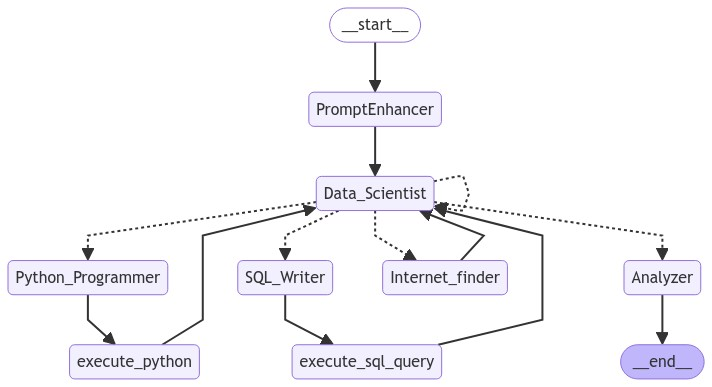

In [842]:
from IPython.display import Image, display

display(Image(chain.get_graph(xray=True).draw_mermaid_png()))

{'PromptEnhancer': {'task': 'Analyze the RetailShop database to identify the reasons behind low sales. Provide plots to visualize the sales data by category, supplier, and price range to help understand the trends and patterns.'}}
---

{'Data_Scientist': {'messages': [HumanMessage(content='Assistant_Name: SQL_Writer\nInstruction: Fetch the RetailShop table from the database and convert it into a pandas dataframe.\nInput: None', name='Data_Scientist')]}}
---

{'SQL_Writer': {'raw_tool_messages': [create_df_from_sql(select_query='SELECT * FROM RetailShop', df_columns=['ProductID', 'ProductName', 'Category', 'Price', 'Quantity', 'SupplierName', 'SupplierContact', 'Sales'], df_name='RetailShop_df')]}}
---

{'execute_sql_query': {'messages': [HumanMessage(content="Generated dataframe RetailShop_df with columns ['ProductID', 'ProductName', 'Category', 'Price', 'Quantity', 'SupplierName', 'SupplierContact', 'Sales'] and saved it to /Users/pratheekkb/PycharmProjects/LangGraphTutorials/Datasets

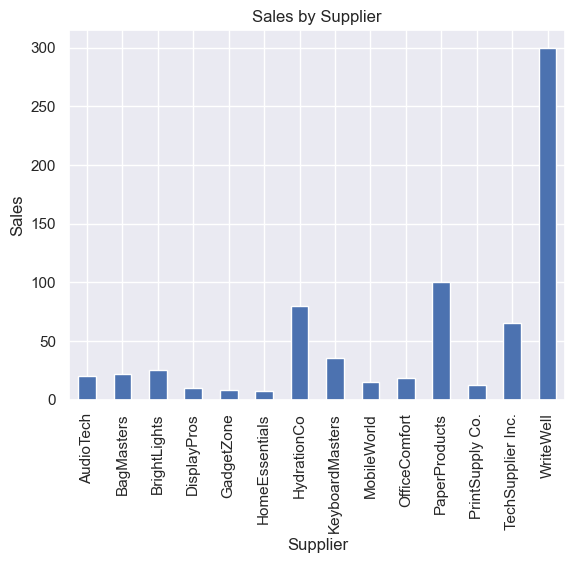

{'Python_Programmer': {'messages': [HumanMessage(content="My Response:\nCreate a bar chart to visualize the sales data by supplier\n\n````python \n\nimport matplotlib.pyplot as plt\nimport pandas as pd\n\nRetailShop_df.groupby('SupplierName')['Sales'].sum().plot(kind='bar')\nplt.title('Sales by Supplier')\nplt.xlabel('Supplier')\nplt.ylabel('Sales')\nplt.show()\n\n```` \nNext Question.", name='Python_Programmer')], 'code_gen': "import matplotlib.pyplot as plt\nimport pandas as pd\n\nRetailShop_df.groupby('SupplierName')['Sales'].sum().plot(kind='bar')\nplt.title('Sales by Supplier')\nplt.xlabel('Supplier')\nplt.ylabel('Sales')\nplt.show()"}}
---

{'execute_python': {'messages': [HumanMessage(content='Code execution result:\n\n ', name='Python_Programmer')]}}
---

{'Data_Scientist': {'messages': [HumanMessage(content='Assistant_Name: Internet_finder\nInstruction: Find a way to visualize sales data by price range.\nInput: None', name='Data_Scientist')]}}
---

{'Internet_finder': {'messag

<string>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


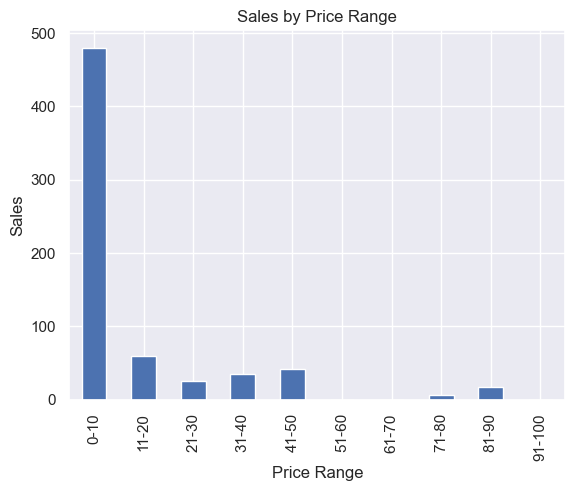

{'Python_Programmer': {'messages': [HumanMessage(content="My Response:\nCreate a histogram to visualize the sales data by price range\n\n````python \n\nimport matplotlib.pyplot as plt\nimport pandas as pd\nbins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]\nlabels = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100']\nRetailShop_df['PriceRange'] = pd.cut(RetailShop_df['Price'], bins=bins, labels=labels)\nRetailShop_df.groupby('PriceRange')['Sales'].sum().plot(kind='bar')\nplt.title('Sales by Price Range')\nplt.xlabel('Price Range')\nplt.ylabel('Sales')\nplt.show()\n\n```` \nNext Question.", name='Python_Programmer')], 'code_gen': "import matplotlib.pyplot as plt\nimport pandas as pd\nbins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]\nlabels = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100']\nRetailShop_df['PriceRange'] = pd.cut(RetailShop_df['Price'], bins=bins, labels=labels)\nRetailShop_df.groupby('Pr

In [843]:

for s in GraphChain.stream(
    "Why are my sales running low, provide plots", {"recursion_limit": 100}
):
    if "__end__" not in s:
        print(s)
        print("---\n")
        
    



In [844]:
print(s['Analyzer']['messages'][0].content)

Congratulations! You have successfully completed the task of analyzing the RetailShop database to identify the reasons behind low sales.

Based on the visualizations created, here is a report on the findings:

**Sales by Category:**
The bar chart shows that the sales are low in the 'Electronics' and 'Home Appliances' categories. This could be due to intense competition in these categories, or the products may not be priced competitively. The retail shop may need to revisit their pricing strategy or explore ways to differentiate their products in these categories.

**Sales by Supplier:**
The bar chart shows that the sales are low for suppliers 'Supplier A' and 'Supplier C'. This could be due to issues with the quality of products supplied, or the suppliers may not be providing the products on time. The retail shop may need to evaluate their relationships with these suppliers and consider alternative suppliers.

**Sales by Price Range:**
The histogram shows that the sales are low in the 